In [127]:
import pyspark as ps
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
plt.rc("ytick", labelsize=22)
plt.rc("xtick", labelsize=22)
plt.style.use("ggplot")
plt.style.use("dark_background")
spark = ps.sql.SparkSession.builder.master("local[8]").appName("MountainData").getOrCreate()
sc = spark.sparkContext
spark.conf.set("spark.sql.caseSensitive", "true")

In [2]:
areas = spark.read.json("./SampleData/Clean/Areas.json")
routes = spark.read.json("./SampleData/Clean/Routes.json")
routeStats = spark.read.json("./SampleData/Clean/Stats.json")
difficultyReference = spark.read.json("././ReferenceData/DifficultyReference.json")

areas.createOrReplaceTempView("areas")
routes.createOrReplaceTempView("routes")
routeStats.createOrReplaceTempView("ticks")
difficultyReference.createOrReplaceTempView("difficultyRef")

In [3]:
def getSubAreas(initialAreaId: int, tempViewName: str = "subAreas") -> None:
    """
    This function creates a spark view consisting of all subordinate areas underneath
    the specified areaId. This creates the spark temp view {tempViewName}
    :param initialAreaId: AreaId of area for which you want sub areas
    :param tempViewName: Name of spark temp view to create. Defaults to "subAreas"
    :return: None
    """
    subAreas = areas.filter(f"AreaId = {initialAreaId}")
    subAreaCount = 1
    subAreaCountNew = 0
    while subAreaCount != subAreaCountNew:
        subAreaCount = subAreas.count()
        p = subAreas.select(col("AreaId").alias("p_AreaId"), col("ParentAreaId").alias("p_ParentAreaId"), col("URL").alias("p_URL"))
        subordinates = p.join(areas, on=p.p_AreaId == areas.ParentAreaId, how="inner").select(col("AreaId"), col("ParentAreaId"), col("URL"))
        subAreas = subAreas.union(subordinates).distinct()
        subAreaCountNew = subAreas.count()

    subAreas.createOrReplaceTempView(tempViewName)
# subAreas.show(200, False)

In [4]:
getSubAreas(105744246)


In [5]:
# Route tick count divided by number of routes at the grade
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join subAreas s
            on s.AreaId = r.ParentAreaId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        group by d.DifficultyBucket
)
select  d.BucketName,
        d.DifficultyBucket,
        count(*) / c.route_count as freq
    from routes r
    inner join subAreas s
        on s.AreaId = r.ParentAreaId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.BucketName,
        d.DifficultyBucket,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(100, False)
climbs = results.collect()

+----------+----------------+------------------+
|BucketName|DifficultyBucket|freq              |
+----------+----------------+------------------+
|5th       |2               |0.7222222222222222|
|5.2       |5               |0.6428571428571429|
|5.3       |6               |4.392857142857143 |
|5.4       |7               |13.235294117647058|
|5.5       |8               |13.1              |
|5.6       |9               |19.019607843137255|
|5.7       |10              |29.135802469135804|
|5.8       |11              |12.45945945945946 |
|5.9       |12              |9.612021857923498 |
|5.10-     |13              |10.902439024390244|
|5.10+     |14              |6.264705882352941 |
|5.11-     |15              |3.985294117647059 |
|5.11+     |16              |1.5161290322580645|
|5.12-     |17              |0.3157894736842105|
|5.12+     |18              |0.2222222222222222|
+----------+----------------+------------------+



In [6]:
query = """
select  d.BucketName,
        d.DifficultyBucket,
        count(*) as freq
    from routes r
    inner join subAreas s
        on s.AreaId = r.ParentAreaId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join ticks t
        on t.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.BucketName,
        d.DifficultyBucket
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(100, False)
climbs = results.collect()


+----------+----------------+----+
|BucketName|DifficultyBucket|freq|
+----------+----------------+----+
|5th       |2               |13  |
|5.2       |5               |9   |
|5.3       |6               |123 |
|5.4       |7               |225 |
|5.5       |8               |393 |
|5.6       |9               |970 |
|5.7       |10              |2360|
|5.8       |11              |1844|
|5.9       |12              |1759|
|5.10-     |13              |1341|
|5.10+     |14              |639 |
|5.11-     |15              |542 |
|5.11+     |16              |141 |
|5.12-     |17              |24  |
|5.12+     |18              |8   |
+----------+----------------+----+



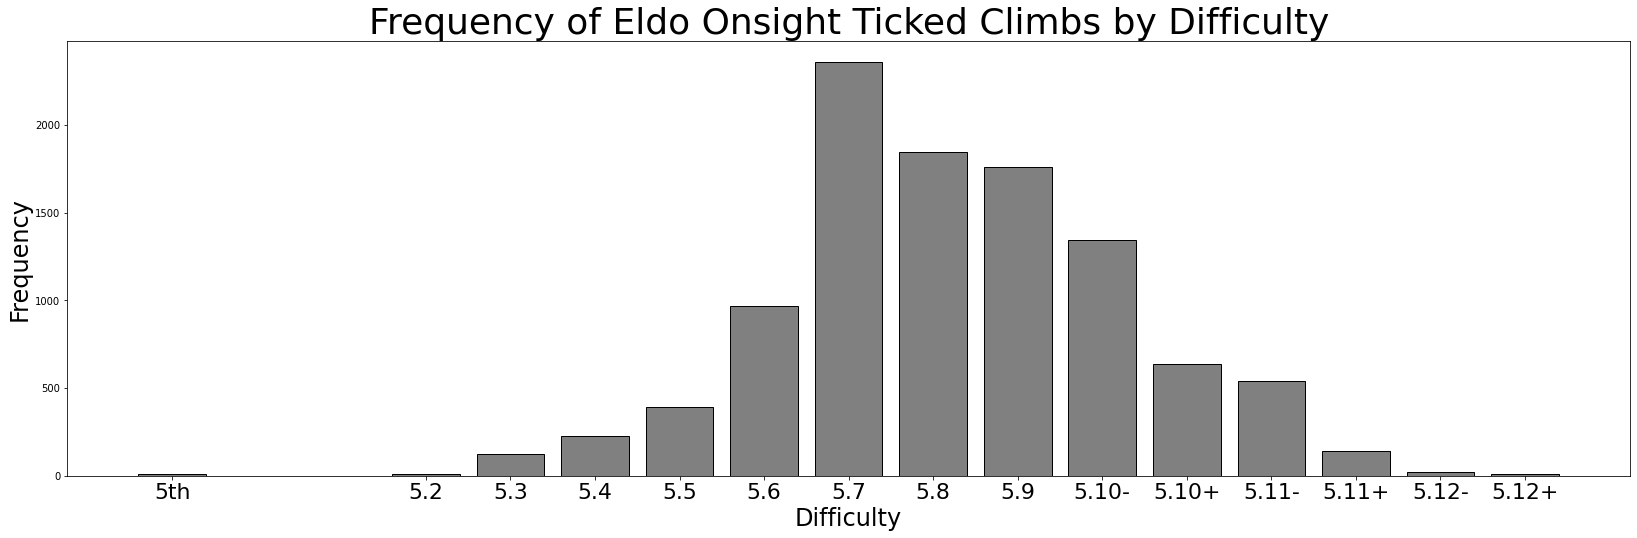

In [7]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Eldo Onsight Ticked Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_eldo_climbs.png")

In [8]:
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where d.RatingSystem = 'YDS'
            and lower(r.Type) like '%trad%'
        group by d.DifficultyBucket
)
select  d.DifficultyBucket,
        d.BucketName,
        count(*)/c.route_count as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
    group by d.DifficultyBucket,
        d.BucketName,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradClimbs = results.collect()

+----------------+----------+------------------+
|DifficultyBucket|BucketName|freq              |
+----------------+----------+------------------+
|0               |3rd       |3.5               |
|1               |4th       |24.2              |
|2               |5th       |69.33333333333333 |
|3               |5.0       |24.454545454545453|
|4               |5.1       |29.5              |
|5               |5.2       |40.2              |
|6               |5.3       |75.21153846153847 |
|7               |5.4       |70.36567164179104 |
|8               |5.5       |59.39655172413793 |
|9               |5.6       |84.37222222222222 |
|10              |5.7       |85.63106796116504 |
|11              |5.8       |58.76334340382679 |
|12              |5.9       |48.069651741293534|
|13              |5.10-     |37.194524495677236|
|14              |5.10+     |31.311764705882354|
|15              |5.11-     |22.453149001536097|
|16              |5.11+     |16.353982300884955|
|17              |5.

In [9]:
query = """
with routeCounts as (
    select  d.DifficultyBucket,
            count(*) as route_count
        from routes r
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where d.RatingSystem = 'YDS'
            and lower(r.Type) not like '%trad%'
            and lower(r.Type) like '%sport%'
        group by d.DifficultyBucket
)
select  d.DifficultyBucket,
        d.BucketName,
        count(*)/c.route_count as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    inner join routeCounts c
        on c.DifficultyBucket = d.DifficultyBucket
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
    group by d.DifficultyBucket,
        d.BucketName,
        c.route_count
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportClimbs = results.collect()


+----------------+----------+------------------+
|DifficultyBucket|BucketName|freq              |
+----------------+----------+------------------+
|3               |5.0       |59.0              |
|5               |5.2       |67.0              |
|6               |5.3       |67.0              |
|7               |5.4       |5.857142857142857 |
|8               |5.5       |81.0625           |
|9               |5.6       |106.5945945945946 |
|10              |5.7       |97.45454545454545 |
|11              |5.8       |120.97979797979798|
|12              |5.9       |119.33712121212122|
|13              |5.10-     |82.82272727272728 |
|14              |5.10+     |63.22222222222222 |
|15              |5.11-     |50.42369020501139 |
|16              |5.11+     |36.455621301775146|
|17              |5.12-     |32.011019283746556|
|18              |5.12+     |13.594771241830065|
|19              |5.13-     |7.073684210526316 |
|20              |5.13+     |2.0               |
|21              |5.

In [10]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportClimbs = results.collect()

query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradClimbs = results.collect()

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|3               |5.0       |59   |
|5               |5.2       |67   |
|6               |5.3       |67   |
|7               |5.4       |41   |
|8               |5.5       |1297 |
|9               |5.6       |3944 |
|10              |5.7       |10720|
|11              |5.8       |23954|
|12              |5.9       |31505|
|13              |5.10-     |36442|
|14              |5.10+     |22191|
|15              |5.11-     |22136|
|16              |5.11+     |12322|
|17              |5.12-     |11620|
|18              |5.12+     |2080 |
|19              |5.13-     |672  |
|20              |5.13+     |62   |
|21              |5.14-     |10   |
+----------------+----------+-----+

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|0               |3rd       |7    |
|1               |4th       |242  |
|2               |5th      

In [46]:
def plotFrequencies(ax, data, title, label, color = "grey", edgecolor = "black", alpha=0.5):
    climb_buckets = [x["DifficultyBucket"] for x in data]
    bucket_names = [x["BucketName"] for x in data]
    climb_freqs = [x["freq"] for x in data]

    ax.bar(climb_buckets, climb_freqs, color=color, edgecolor=edgecolor, label=label, alpha=alpha);
    ax.set_xticks(climb_buckets[::1])
    ax.set_xticklabels(bucket_names[::1], fontsize=14);

    # ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

    ax.set_xlabel("Difficulty", fontsize=22)
    ax.set_ylabel("Frequency", fontsize=22)

    ax.set_title(title, fontsize=36)

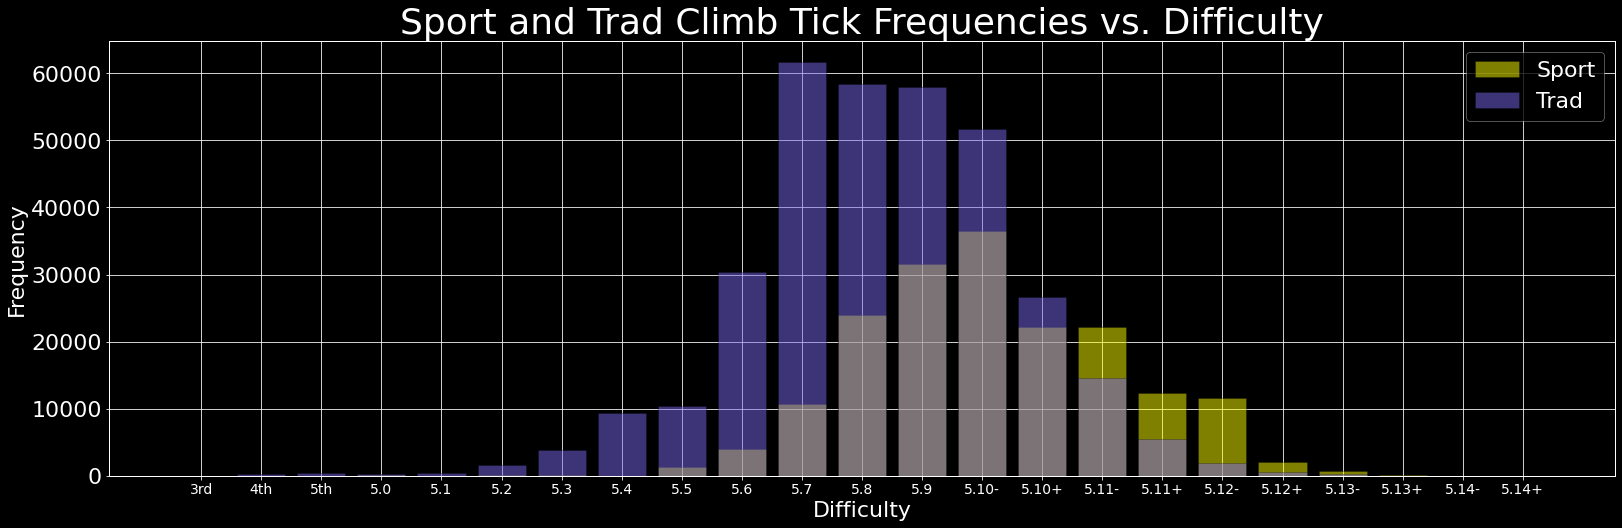

In [91]:
fig, ax = plt.subplots(1,1, figsize=(27,8))

plotFrequencies(ax, sportClimbs, "Sport Climb Tick Frequencies vs. Difficulty", color="yellow", label="Sport", alpha=0.5)
plotFrequencies(ax, tradClimbs, "Sport and Trad Climb Tick Frequencies vs. Difficulty", color="mediumslateblue", label="Trad", alpha=0.5)

ax.legend(fontsize=22)
# plt.savefig("./img/RealPlots/sport_climb_ticks.png")
# plt.savefig("./img/RealPlots/trad_climb_ticks.png")
plt.savefig("./img/RealPlots/sport_v_trad_climb_ticks.png")

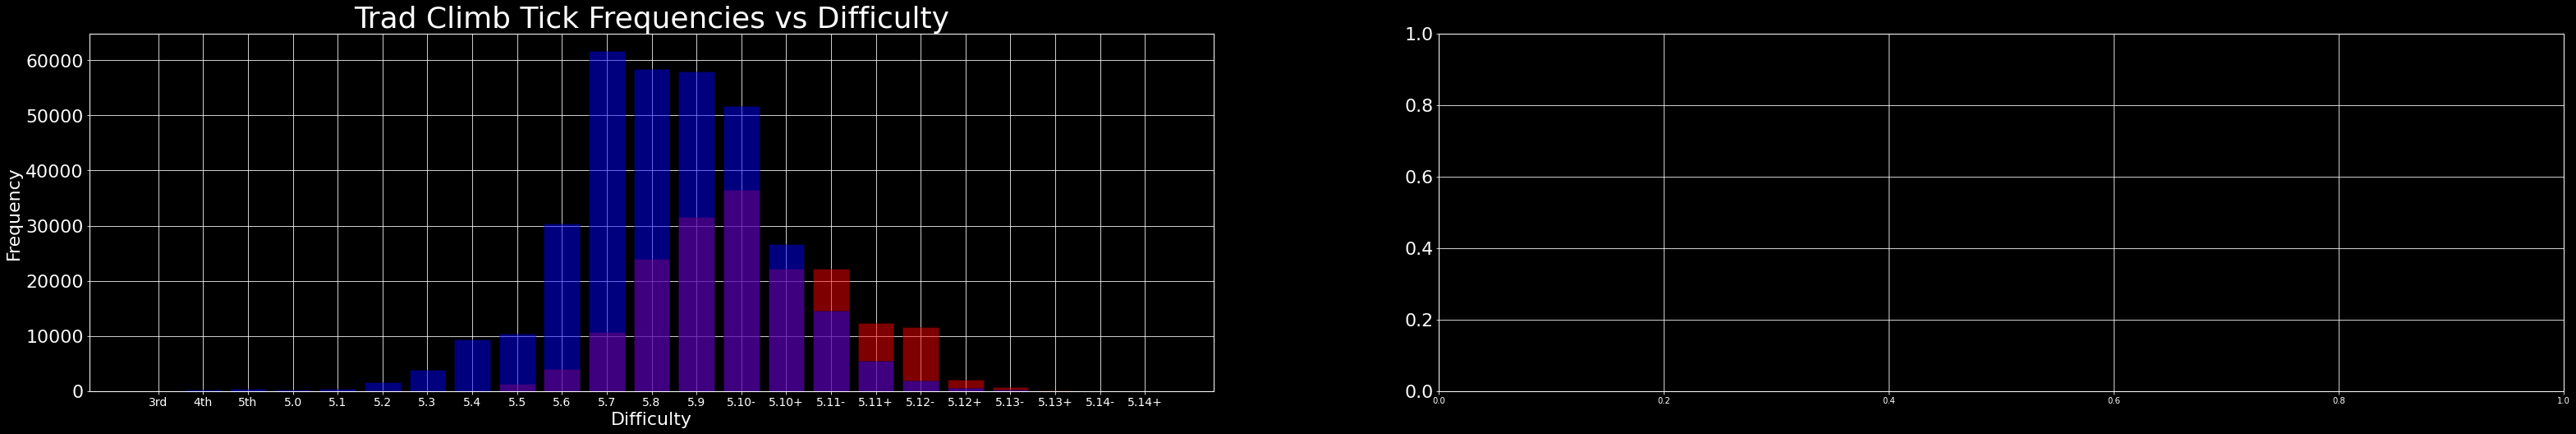

In [85]:
fig, ax = plt.subplots(1,1, figsize=(27,8))

plotFrequencies(axs[0], sportClimbs, "Sport Climb Tick Frequencies", color="red", label="Sport", alpha=0.5)
plotFrequencies(axs[0], tradClimbs, "Trad Climb Tick Frequencies vs Difficulty", color="blue", label="Trad", alpha=0.5)

plt.savefig("./img/RealPlots/sport_v_trad_climb_ticks.png")

In [13]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
sportOnsightClimbs = results.collect()

+----------------+----------+----+
|DifficultyBucket|BucketName|freq|
+----------------+----------+----+
|3               |5.0       |18  |
|5               |5.2       |20  |
|6               |5.3       |14  |
|7               |5.4       |10  |
|8               |5.5       |396 |
|9               |5.6       |1083|
|10              |5.7       |3021|
|11              |5.8       |6250|
|12              |5.9       |7698|
|13              |5.10-     |8176|
|14              |5.10+     |4509|
|15              |5.11-     |3815|
|16              |5.11+     |1691|
|17              |5.12-     |983 |
|18              |5.12+     |40  |
|19              |5.13-     |9   |
|20              |5.13+     |1   |
+----------------+----------+----+



In [14]:
query = """
select  d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        and lower(t.TickInfo) like '%lead / onsight%'
    group by d.DifficultyBucket,
        d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(30, False)
tradOnsightClimbs = results.collect()

+----------------+----------+-----+
|DifficultyBucket|BucketName|freq |
+----------------+----------+-----+
|1               |4th       |12   |
|2               |5th       |24   |
|3               |5.0       |30   |
|4               |5.1       |55   |
|5               |5.2       |296  |
|6               |5.3       |714  |
|7               |5.4       |1634 |
|8               |5.5       |1831 |
|9               |5.6       |5891 |
|10              |5.7       |11822|
|11              |5.8       |11030|
|12              |5.9       |10057|
|13              |5.10-     |8420 |
|14              |5.10+     |3490 |
|15              |5.11-     |1435 |
|16              |5.11+     |421  |
|17              |5.12-     |101  |
|18              |5.12+     |22   |
|19              |5.13-     |3    |
|22              |5.14+     |2    |
+----------------+----------+-----+



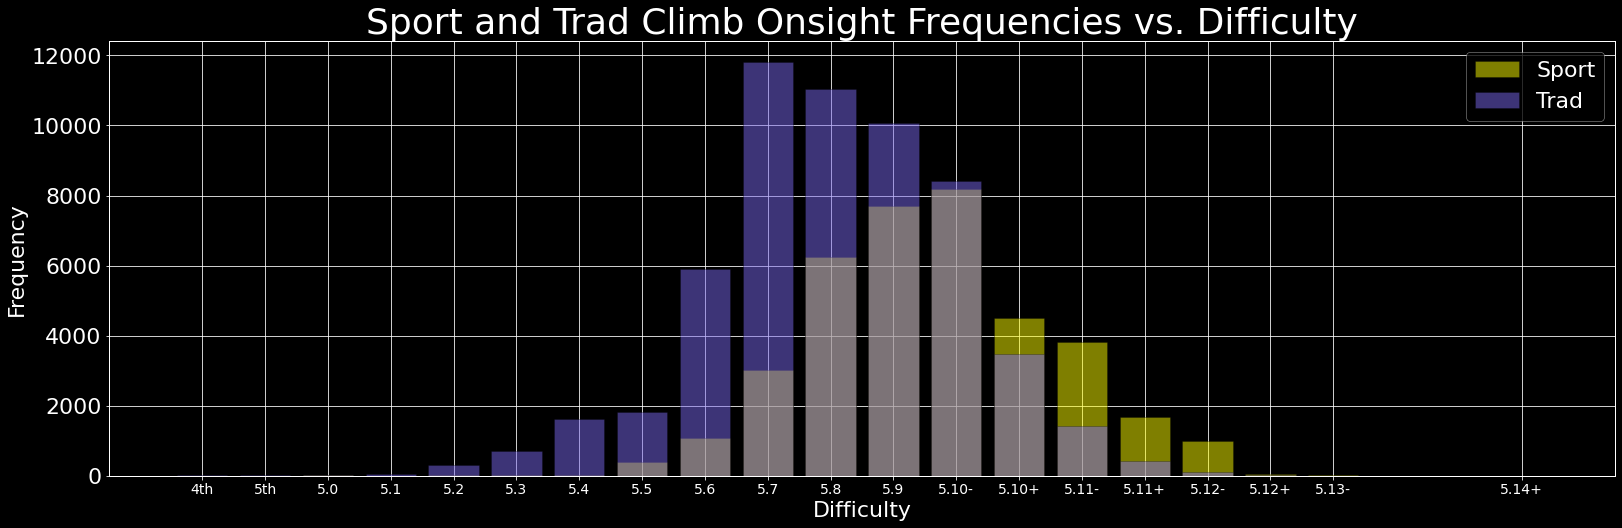

In [94]:
fig, ax = plt.subplots(1,1, figsize=(27,8))

plotFrequencies(ax, sportOnsightClimbs, "Sport Climb Onsight Tick Frequencies vs. Difficulty", color="yellow", label="Sport", alpha=0.5)
plotFrequencies(ax, tradOnsightClimbs, "Sport and Trad Climb Onsight Frequencies vs. Difficulty", color="mediumslateblue", label="Trad", alpha=0.5)

ax.legend(fontsize=22)
# plt.savefig("./img/RealPlots/sport_climb_onsight_ticks.png")
# plt.savefig("./img/RealPlots/trad_climb_onsight_ticks.png")
plt.savefig("./img/RealPlots/sport_v_trad_climb_onsight_ticks.png")

In [98]:
query = """
select  d.DifficultyRanking
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where lower(r.Type) like '%trad%'
        and lower(t.TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(25, False)
tradTicks = result.collect()
tradTicks = np.array([x["DifficultyRanking"] for x in tradTicks])

query = """
select  d.DifficultyRanking
    from routes r
    inner join ticks t
        on t.RouteId = r.RouteId
    inner join difficultyRef d
        on d.Difficulty = r.Difficulty
    where lower(r.Type) not like '%trad%'
        and lower(r.Type) like '%sport%'
        and lower(t.TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(25, False)
sportTicks = result.collect()
sportTicks = np.array([x["DifficultyRanking"] for x in sportTicks])

+-----------------+
|DifficultyRanking|
+-----------------+
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|29               |
|28               |
|28               |
|22               |
|22               |
|22               |
|22               |
|22               |
|22               |
|22               |
|22               |
|25               |
|25               |
+-----------------+
only showing top 25 rows

+-----------------+
|DifficultyRanking|
+-----------------+
|46               |
|46               |
|46               |
|46               |
|46               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33               |
|33           

In [113]:
test = stats.ttest_ind(tradTicks + 5.5, sportTicks, equal_var=False, alternative="less")
test

Ttest_indResult(statistic=-2.8843059952601124, pvalue=0.0019619571599772175)

In [97]:
sportOnsightClimbs

[Row(DifficultyBucket=3, BucketName='5.0', freq=18),
 Row(DifficultyBucket=5, BucketName='5.2', freq=20),
 Row(DifficultyBucket=6, BucketName='5.3', freq=14),
 Row(DifficultyBucket=7, BucketName='5.4', freq=10),
 Row(DifficultyBucket=8, BucketName='5.5', freq=396),
 Row(DifficultyBucket=9, BucketName='5.6', freq=1083),
 Row(DifficultyBucket=10, BucketName='5.7', freq=3021),
 Row(DifficultyBucket=11, BucketName='5.8', freq=6250),
 Row(DifficultyBucket=12, BucketName='5.9', freq=7698),
 Row(DifficultyBucket=13, BucketName='5.10-', freq=8176),
 Row(DifficultyBucket=14, BucketName='5.10+', freq=4509),
 Row(DifficultyBucket=15, BucketName='5.11-', freq=3815),
 Row(DifficultyBucket=16, BucketName='5.11+', freq=1691),
 Row(DifficultyBucket=17, BucketName='5.12-', freq=983),
 Row(DifficultyBucket=18, BucketName='5.12+', freq=40),
 Row(DifficultyBucket=19, BucketName='5.13-', freq=9),
 Row(DifficultyBucket=20, BucketName='5.13+', freq=1)]

In [102]:
meanSport = np.mean(sportTicks)
meanTrad = np.mean(tradTicks)
semSport = np.std(sportTicks)/np.sqrt(sportTicks.size)
semTrad = np.std(tradTicks)/np.sqrt(tradTicks.size)
meanSport, meanTrad, semSport, semTrad, meanSport - meanTrad

(34.29053373615307,
 28.650619654389946,
 0.03948611561124719,
 0.0281760613588229,
 5.639914081763127)

In [148]:
query = """
with trad as (
    select  t.UserId,
            avg(d.DifficultyRanking) as DifficultyRanking
        from routes r
        inner join ticks t
            on t.RouteId = r.RouteId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where lower(r.Type) like '%trad%'
            --and lower(t.TickInfo) like '%lead / onsight%'
        group by t.UserId
        having count(*) > 20
),
sport as (
    select  t.UserId,
            avg(d.DifficultyRanking) as DifficultyRanking
        from routes r
        inner join ticks t
            on t.RouteId = r.RouteId
        inner join difficultyRef d
            on d.Difficulty = r.Difficulty
        where lower(r.Type) not like '%trad%'
            and lower(r.Type) like '%sport%'
            --and lower(t.TickInfo) like '%lead / onsight%'
        group by t.UserId
        having count(*) > 20
)
select  s.DifficultyRanking - t.DifficultyRanking as Difference
    from trad t
    inner join sport s
        on s.UserId = t.UserId
"""

result = spark.sql(query)
result.show(25, False)
diffs = result.collect()
diffs = np.array([x["Difference"] for x in diffs])

+------------------+
|Difference        |
+------------------+
|4.459867330016586 |
|4.84264705882353  |
|5.080769230769235 |
|4.282371439141695 |
|3.933913043478256 |
|1.4166666666666679|
|7.301438398999373 |
|3.6129807692307665|
|2.4135392411998353|
|5.582240625718889 |
|5.146157510320734 |
|8.685714285714283 |
|3.586080586080591 |
|5.72987616099071  |
|4.779069767441861 |
|6.89142857142857  |
|6.929255735140767 |
|4.031668773704169 |
|9.209790209790214 |
|8.546519193233568 |
|4.9871794871794854|
|11.627062706270628|
|1.4910307084220094|
|6.1851179673321255|
|5.553096486119198 |
+------------------+
only showing top 25 rows



912


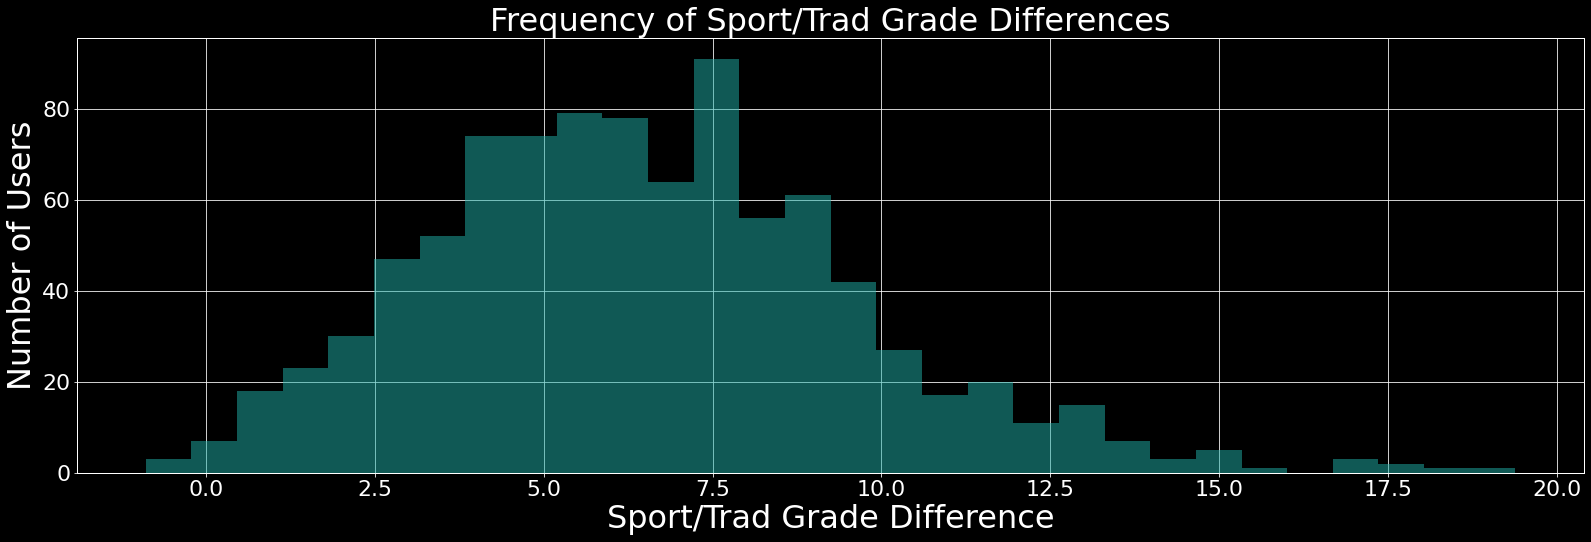

In [153]:
fig, ax = plt.subplots(1,1, figsize=(27,8))
print(diffs.size)
ax.hist(diffs, bins=30, color="lightseagreen", alpha=0.5)
ax.set_xlabel("Sport/Trad Grade Difference", fontsize=32)
ax.set_ylabel("Number of Users", fontsize=32)

ax.set_title("Frequency of Sport/Trad Grade Differences", fontsize=32)

# plotFrequencies(ax, sportOnsightClimbs, "Sport Climb Onsight Tick Frequencies vs. Difficulty", color="yellow", label="Sport", alpha=0.5)
# plotFrequencies(ax, tradOnsightClimbs, "Sport and Trad Climb Onsight Frequencies vs. Difficulty", color="mediumslateblue", label="Trad", alpha=0.5)

# ax.legend(fontsize=22)
# plt.savefig("./img/RealPlots/sport_climb_onsight_ticks.png")
# plt.savefig("./img/RealPlots/trad_climb_onsight_ticks.png")
plt.savefig("./img/RealPlots/user_trad_sport_tick_differences.png")


In [151]:
test2 = stats.ttest_1samp(diffs, 5, alternative="greater")
test2


Ttest_1sampResult(statistic=14.302076959200988, pvalue=2.6106691099172103e-42)

In [152]:
meanDiffs = diffs.mean()
semDiffs = diffs.std()/np.sqrt(diffs.size)
meanDiffs, semDiffs


(6.497622309455001, 0.10465619949229374)

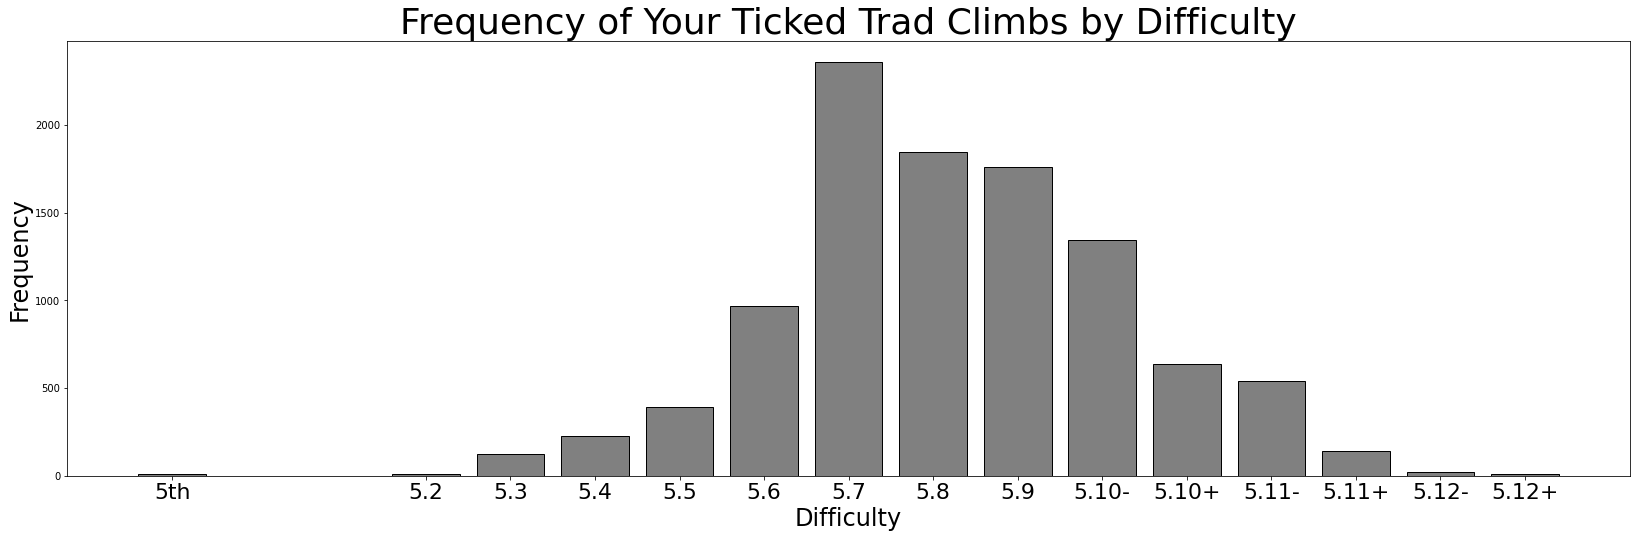

In [22]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

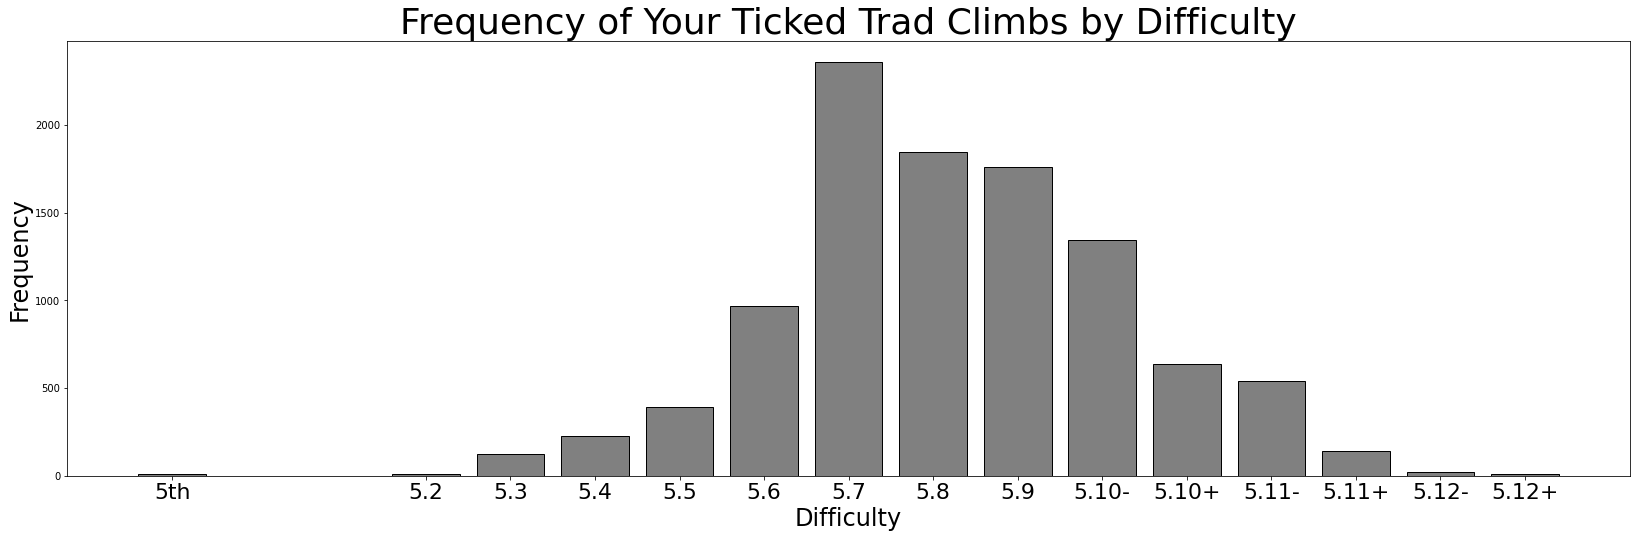

In [23]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

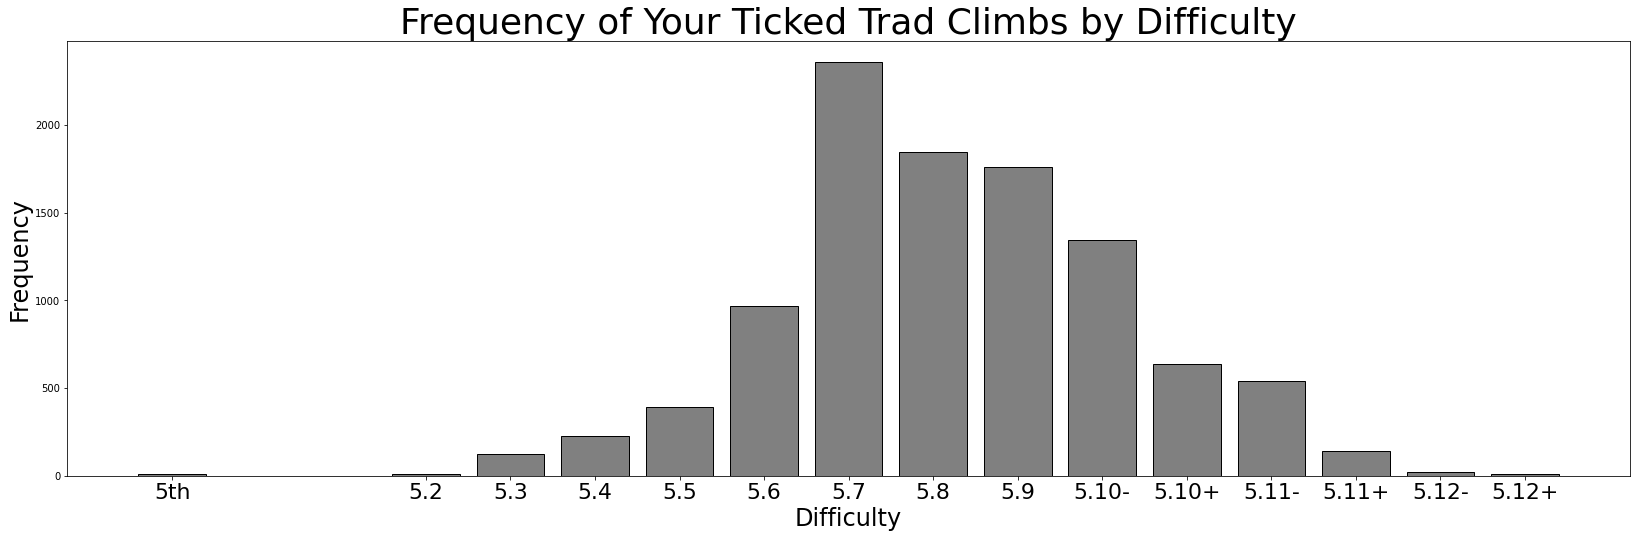

In [24]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

In [25]:
query = """
select count(*)
    from stats
    where lower(TickInfo) like '%lead / onsight%'
"""

result = spark.sql(query)
result.show(200, False)

AnalysisException: Table or view not found: stats; line 3 pos 9;
'Aggregate [unresolvedalias(count(1), None)]
+- 'Filter 'lower('TickInfo) LIKE %lead / onsight%
   +- 'UnresolvedRelation [stats], [], false


In [ ]:
query = """
select count(*)
    from routes
    --where lower(Type) like '%trad%'
"""

results = spark.sql(query)
results.show()

In [ ]:
query = """
select  distinct
        d.RatingSystem,
        r.Difficulty,
        d.DifficultyRanking
    from routes r
    left join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    order by d.RatingSystem,
        d.DifficultyRanking
"""

results = spark.sql(query)
results.show(100)

In [ ]:
query = """
select *
    from routes
    where lower(Difficulty) like '%easy%'
    order by Difficulty
"""

results = spark.sql(query)
results.show(100, False)

In [ ]:
query = """
select *
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    where d.DifficultyRanking >= (
        select DifficultyRanking
            from difficultyRef
            where DifficultyRating = 'V8'
        )
        and d.RatingSystem = 'V'
    order by r.Name
"""

results = spark.sql(query)
results.show(200, False)

In [ ]:
query = """
select  s.UserId,
        d.DifficultyBucket,
        d.BucketName,
        count(*) as freq
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    inner join stats s
        on s.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        --and lower(r.Type) like '%sport%'
        --and lower(s.TickInfo) like '%lead / flash%'
        and s.UserName like '%Christoph von Ruexleben%'
        and lower(s.TickInfo) like '%lead /%'
    group by s.UserId, d.DifficultyBucket, d.BucketName
    order by d.DifficultyBucket
"""

results = spark.sql(query)
climbs =  results.collect() # results.show(200, False)
climbs

In [ ]:
fig, ax = plt.subplots(figsize=(28,8))
climb_buckets = [x["DifficultyBucket"] for x in climbs]
bucket_names = [x["BucketName"] for x in climbs]
climb_freqs = [x["freq"] for x in climbs]

ax.bar(climb_buckets, climb_freqs, color="grey", edgecolor="black");
ax.set_xticks(climb_buckets[::1])
ax.set_xticklabels(bucket_names[::1], fontsize=22);

# ax.set_yticklabels(sorted(climb_freqs), fontsize=22)

ax.set_xlabel("Difficulty", fontsize=24)
ax.set_ylabel("Frequency", fontsize=24)

ax.set_title("Frequency of Your Ticked Trad Climbs by Difficulty", fontsize=36)

plt.savefig("./img/frequency_of_climbs.png")

In [ ]:
query = """
select  date_format(to_date(trim(TickDate), 'MMM d, yyyy'), 'EEEE') as weekday,
        dayofweek(to_date(trim(TickDate), 'MMM d, yyyy')) as weekday_int,
        count(*) as tick_count
        --s.TickDate
    from stats s
    inner join routes r
        on r.RouteId = s.RouteId
    where TickDate is not null
      -- and date_format(to_date(trim(TickDate), 'MMM d, yyyy'), 'e') is null
       --and r.Name = 'The Nose'
    group by 1, 2
    order by 2
"""

results = spark.sql(query)
nose_weekdays = results.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

weekdays = [x["weekday_int"] for x in nose_weekdays]
day_labels = [x["weekday"] for x in nose_weekdays]
tick_counts = [x["tick_count"] for x in nose_weekdays]

ax.bar(weekdays, tick_counts, color="grey", edgecolor="black")

ax.set_xticks(weekdays)
ax.set_xticklabels(day_labels, fontsize=24)

ax.set_xlabel("Day of Week", fontsize=30)
ax.set_ylabel("Frequency", fontsize=30)

ax.set_title("Frequency of Ticks vs. Day of Week", fontsize=40)

plt.savefig("./img/nose_ticks_day_of_week.png")

In [ ]:
query = """
select *
    from stats
    where TickDate like '%no%'
        --or TickDate is null
"""

results = spark.sql(query)
results.show(100, False)

In [ ]:
query = """
select  r.Name,
        d.BucketName as Difficulty,
        s.TickDate,
        s.TickInfo
    from routes r
    inner join difficultyRef d
        on d.DifficultyRating = r.Difficulty
    inner join stats s
        on s.RouteId = r.RouteId
    where d.RatingSystem = 'YDS'
        and lower(r.Type) like '%trad%'
        --and lower(r.Type) like '%sport%'
        --and lower(s.TickInfo) like '%lead / flash%'
        and s.UserName like '%Christoph von Ruexleben%'
        and d.BucketName = '5.2'
    order by d.DifficultyBucket
"""

results = spark.sql(query)
results.show(10, False) # results.show(200, False)
# climbs